# Inference in Pyro: From Stochastic Functions to Marginal Distributions

In [2]:
# import some dependencies
import numpy as np
import matplotlib.pyplot as plt

import torch

import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist

torch.manual_seed(101);

In [3]:
def scale(guess):
    # The prior over weight encodes our uncertainty about our guess
    weight = pyro.sample("weight", dist.Normal(guess, 1.0))
    # This encodes our belief about the noisiness of the scale:
    # the measurement fluctuates around the true weight
    return pyro.sample("measurement", dist.Normal(weight, 0.75))

In [8]:
posterior = pyro.infer.Importance(scale, num_samples=100)

In [16]:
guess = 8

marginal = pyro.infer.EmpiricalMarginal(posterior.run(guess))
print(marginal())

tensor(8.4590)


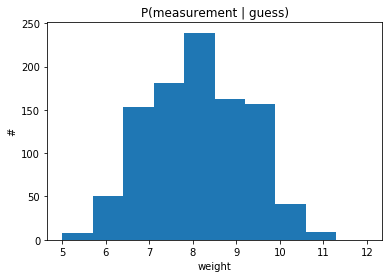

In [18]:
plt.hist([marginal().item() for _ in range(1000)], range=(5.0, 12.0))
plt.title("P(measurement | guess)")
plt.xlabel("weight")
plt.ylabel("#");